In [84]:
import fastbook
fastbook.setup_book()

In [85]:
from fastai.vision.all import *
from fastbook import *

In [86]:
# Access MNIST dataset from fastai
path = untar_data(URLs.MNIST_SAMPLE)

In [87]:
Path.BASE_PATH = path

In [88]:
# See the directory contents for the MNIST dataset
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [89]:
# See the contents of our train folder - '3' and '7' will be our labels
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [90]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [91]:
# Use Image class from Python Imaging Library (PIL) to open a sample image of 3
im_3_path = threes[1]
im_3 = Image.open(im_3_path)
im_3

To see the numbers that make up this image - we need to convert it to either a *NumPy Array* or a *PyTorch Tensor*.

The `4:10` in the code below represents that we request the rows/columns from index 4 (**inclusive**) to index 10 (**not inclusive**). So this is basically showing the top-left corner of the image since the indices work from top-to-bottom and left-to-right.

In [92]:
# NumPy Array
array(im_3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [93]:
# PyTorch Tensor
tensor(im_3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can now take a look at a larger section of the image and see how these values help represent the number 3.

A few things to note is that this image is 28 x 28 - meaning it has 784 pixels in total. Each pixel has a value from 0-255, where 0 is white and 255 is black. Anything in between is some type of gray.

In [94]:
im_3_tensor = tensor(im_3)
df = pd.DataFrame(im_3_tensor[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Attempt 1: Pixel Similarity

To solve this classification problem, we can start by simply taking the average pixel values of an image that represents that number 3 and the average of the pixel values of an image that represents 7. We can then take the average of the pixels of any image and cross-reference it to these two base points to see if the image represents a 3 or a 7. 

Start by creating a tensor of all of our 3s stacked together - by first creating a plain list of the single image tensors using **Python List Comprehension**.

**Python List Comprehension**: A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but **much faster** than the alternative ways of creating the same list with a loop.

In [95]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

len(three_tensors), len(seven_tensors)

(6131, 6265)

Since all of the images are now in tensor format, to display them as images, use fastai's `show_image` function to do so.

<Axes: >

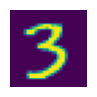

In [96]:
show_image(three_tensors[1])

To get the average value for every pixel across all the images, we need to combine all the images into a single, three-dimensional tensor - **rank 3 tensor**. Individual tensors can be stacked into a collection of tensors using PyTorch's `stack`.

Also, whenever taking the mean in PyTorch, ints need to be converted into floats. This is done using `.float()`. We're not taking the mean right now but we may as well cast the tensor into that type during this computation.

In [97]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

`.shape` tells us that our `stacked_threes` includes 6131 images, each of which are 28x28 pixels. Literally think of it like a 3-dimensional rubix cube except it's not 3x3x3, it's 6131x28x28. Each little square in this rubix cube is a pixel intensity for one of our images.

`len()` of a tensor's `shape` will tell us the tensor rank.

In [98]:
len(stacked_sevens.shape)

3

### Key Jargon to Remember

* **Rank**: The number of axes or dimensions in a tensor - *6131* **(1)**, *28* **(2)**, *28* **(3)**. Thus, **3** dimensions.
* **Shape**: The size of each axis of a tensor - *6131, 28, 28*.
* *The **length** of a tensor's **shape** is its **rank***.

A tensor's rank can be directly found with `ndim`:

In [99]:
stacked_threes.ndim

3

Now, computing the mean or "ideal" 3 & 7 (the one with average pixel values that we'll compare future images to) can be done by calculating the mean along *dimension 0* - the 6131 images.

In [100]:
mean_3 = stacked_threes.mean(0)
mean_7 = stacked_sevens.mean(0)

mean_3.shape, mean_7.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

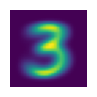

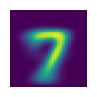

In [101]:
show_image(mean_3), show_image(mean_7);

The images above are dark where all the images agree they should be dark and blurry where the images disagree.

One of the problems we may encounter with taking the differences between the pixels of the sample image and the ideal image is that some differences will be positive and others will be negative - causing them to cancel out when averaged. 

As a result, there are two key ways of determining the distance a sample image has from our mean/ideal image:

* **Mean Absolute Difference - L1 Norm**: Take the mean of the *absolute value* of differences of the pixels.
* **Root Mean Squared Error (RMSE) - L2 Norm**: Take the mean of the *squared value* of differences of the pixels and then take the *square root* (to undo the squaring).  

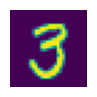

In [102]:
# Sample Image
sample_3 = stacked_threes[2]
show_image(sample_3);

In [103]:
# Mean Absolute Difference
dist_3_abs = (sample_3 - mean_3).abs().mean()

# Root Mean Squared Error (RMSE)
dist_3_sqr = ((sample_3 - mean_3)**2).mean().sqrt()

dist_3_abs, dist_3_sqr

(tensor(0.1100), tensor(0.1980))

In [104]:
dist_7_abs = (sample_3 - mean_7).abs().mean()
dist_7_sqr = ((sample_3 - mean_7)**2).mean().sqrt()

dist_7_abs, dist_7_sqr

(tensor(0.1541), tensor(0.2974))

It can be seen that in both cases above (L1 Norm and L2 Norm) that the values are lower against our ideal 3, indicating that the sample image is likely a 3.

Instead of having to manually calculate L1 Norm and L2 Norm, PyTorch provides both of these as **loss functions** inside `torch.nn.functional` - often (and with fastai, automatically) imported as `F`.

* `F.l1_loss()` = mean absolute difference
* `F.mse_loss()` = mean squared error

In [105]:
F.l1_loss(sample_3.float(), mean_7), F.mse_loss(sample_3.float(), mean_7)

(tensor(0.1541), tensor(0.0885))

## Side Notes: NumPy Arrays and PyTorch Tensors

PyTorch tensors are used instead of NumPy arrays in deep learning since the latter does not support using the GPU or calculating gradients.

Below is a summary of important functions and tricks to know for both NumPy and PyTorch:

1. Creating an array or tensor

In [106]:
data = [[1, 2, 3], [4, 5, 6]]

arr = array(data)
tnsr = tensor(data)

arr, tnsr

(array([[1, 2, 3],
        [4, 5, 6]]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

The following operations will be shown only on a PyTorch tensor, but the *syntax is identical* for NumPy arrays.

2. Selecting a row

In [107]:
tnsr[1]

tensor([4, 5, 6])

3. Selecting a column, by using `:` to indicate all of the *first axis* (rows) - in this case, axis refers to the dimension

In [108]:
tnsr[:, 1]

tensor([2, 5])

4. Combine these selections with Python slice syntax - `[start:end]` (where `end` is excluded)

In [109]:
tnsr[1, :3]

tensor([4, 5, 6])

5. Standard operators such as `+`, `-`, `*`, and `/` all work

In [110]:
tnsr+1

tensor([[2, 3, 4],
        [5, 6, 7]])

6. Tensors have a type

In [111]:
tnsr.type()

'torch.LongTensor'

7. The type of a tensor changes automatically from `int` to `float` when needed

In [112]:
tnsr*2.1

tensor([[ 2.1000,  4.2000,  6.3000],
        [ 8.4000, 10.5000, 12.6000]])

## Computing Metrics Using Broadcasting

Back to the original MNIST problem, to know if the baseline model we created is any good we need some metric to measure success. 

We could use MSE or mean absolute error and take the average of them over the whole dataset - but these numbers are difficult to interpret for most. *Accuracy* is a far easier to understand metric for classification models.

Let's test the model on the MNIST validation set (not really necessary to use validation set because we don't have any trained components but just for the sake of best practice).

In [113]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Now we want to write a function that can determine the 'distance' (our metric for how far off it is) between a sample image and our mean/ideal image.

In [114]:
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2)) # (-1, -2) -> calculate the mean of the last two dimensions of the passed in tensors (the 28, 28 height/width pixels - not # of images)

mnist_distance(sample_3, mean_3)

tensor(0.1100)

Normally, you would have to write some type of loop to compare all the pixel values (28, 28) of all the images in our validation set against our `mean_3` image and see what the loss looks like for each of them. 

However, in PyTorch, you can actually pass in an entire rank-3 tensor into the `mnist_distance` function even though the function looks like it's only meant for comparing two individuals images of the *same size*.

In [115]:
# Clearly, the shapes below don't match (rank-3 vs. rank-2)
valid_3_tens.shape, mean_3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

In [116]:
# But the distance calculation still works!
valid_3_dist = mnist_distance(valid_3_tens, mean_3)

valid_3_dist, valid_3_dist.shape

(tensor([0.1358, 0.1117, 0.1361,  ..., 0.1114, 0.1087, 0.1242]),
 torch.Size([1010]))

PyTorch uses **broadcasting** - automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. 

If you look in the `mnist_distance` function, it is apparent that we're only comparing the height/width of images (`.mean(-1, -2)`); but, our validation set has 1010 of these 28x28 images. 

So, what PyTorch is basically doing is expanding our `mean_3` image into a rank-3 tensor (from it's current state as a rank-2 tensor) by treating it as if it were 1010 copies of the single image it is representing. This allows for to be subtracted from each image in the `valid_3_tens` tensor. 

Taking a look at the shape of the tensor during subtraction between `valid_3_tens` and `mean_3`, we can clearly see the effect of **broadcasting**.

In [117]:
(valid_3_tens - mean_3).shape

torch.Size([1010, 28, 28])

A few important points of **broadcasting**:

* Does not actually copy `mean_3` 1010 times - it just *pretends* it's a tensor of that shape without allocating additional memory
* Entire calculation happens in C (or, if using a GPU, in does the entire calculation in CUDA - the equivalent of C on the GPU) which is more than 10,000x faster (>1,000,000x on GPU) than typical Python.

The `.abs` in our function is an elementwise operation (just like `+` or `-` on a tensor) so we get 1010 matrices of absolute values. Then, as explained, we use `mean((-1, -2))` on these 1010 matrices to get the mean of the horizontal and vertical dimensions of our image. 

We can define a function to validate if an image is the digit 3 by using the rule that if the distance to the ideal 3 is less than the distance to the ideal 7, then the image is a 3.

In [118]:
def is_3(x): return mnist_distance(x, mean_3) < mnist_distance(x, mean_7)

# Show True and 1.0 (which means True)
is_3(sample_3), is_3(sample_3).float()

(tensor(True), tensor(1.))

In [119]:
# Test on entire validation set for 3s
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [120]:
# Create an accuracy for 3s and 7s
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()

accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

In [121]:
# Collective accuracy
(accuracy_3s + accuracy_7s) / 2

tensor(0.9511)

This model, which has no training, is getting around a collective accuracy of 95%!

However, we're only testing it on differentiating between 3s and 7s, which is not a very hard task since they're extremely different numbers. 

We want a system that can actually **learn** - automatically modify itself to improve its performance.

## Stochastic Gradient Descent (SGD)

Approach 1 around pixel similarity does not create a model that learns: no weight assignment or any way of improving based on tested effectiveness. 

A better approach is to have **weights** associated with each individual pixels, such that high weights are associated with pixels that are most likely to be black. In this scenario, pixels in the bottom right of a number like 7 are not likely to be activated so they should have a low weight for 7 but a high weight for an 8.

A function to described the probability of a number being an 8 could look something like the following:

`def probability_eight(x, w): return (x * w).sum()`

Where `x` is the image represented as a vector (all rows in a line) and `w` are the weights represented as a vector. We want to update these weights iteratively and find the specific values for each weight value in the vector so that the model is the most accurate.  

To make the `probability_eight()` function into a machine learning classifier, we must using **gradient descent**.

### Gradient Descent 

1. **Initialize** the weights
2. For each training image, use the weights to **predict** if the image is a 3 or 7
3. Calculate how good this prediction was (**loss**)
4. Calculate the **gradient** for each weight - understanding how changing that weight would change the loss
5. **Step** (change) all the weights based on the gradient calculation
6. Go to step 2 and repeat the process
7. Iterate until satisfied with the training process

There are different ways to execute these steps, here are some general principals to follow:

* **Initialize**: The parameters should initialize to random values
* **Loss**: Return a small number if the prediction was good and a large number if the prediction was bad
* **Step**: Use the **gradient** calculation to determine in which direction to change a weight and by roughly how much. 
* **Stop**: Generally stop after the model's performance begins to decline

### Gradient Descent w/ Quadratics

To understand gradient descent, a sample of a quadratic function can be used. The quadratic will represent our loss function and `x` is a weight parameter.

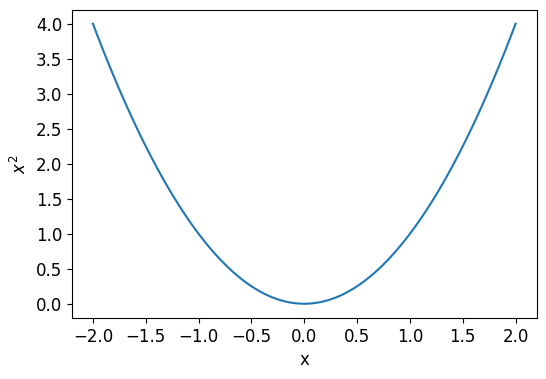

In [122]:
def f(x): return x**2

plot_function(f, 'x', '$x^2$')

Start with the first few steps of gradient descent - initializing a random parameter and calculating its loss

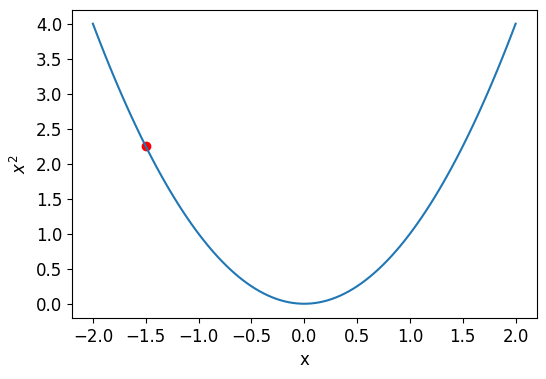

In [123]:
plot_function(f, 'x', '$x^2$')
plt.scatter(-1.5, f(-1.5), color='red');

If we take a look at the slope of the parameter, we can see what happens if we increased or decreased (in this case, decreased) the value of our parameter.

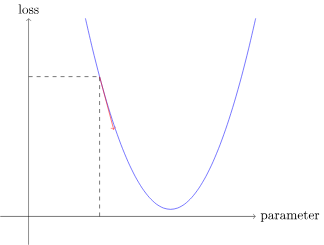

We want to continually make small adjustments in the direction of this slope, calculate our loss again, and continually repeat until we get to the lowest point on our curve.

### Calculating Gradients

If we find the derivative of a certain weight, we can understand the rate of change at that specific point. From there, it's easy to calculate the gradient (the slope) and understand the direction it's pointing in and it's magnitude. 

Since our function will have many weights, when the derivative is calculated, you'll get back a gradient for every weight - to sort this out, you can use partial differentiation to find the gradient of that particular weight while holding the gradient of all the other ones constant. 

PyTorch calculates derivatives and gradients for us. Start by picking a tensor value for which we want gradients at:

In [124]:
xt = tensor(3.).requires_grad_()

`requires_grad_()` tells PyTorch that we want to calculate the gradient with respect to that variable at that value.

**One important note -** in math or physics, the gradient of a function returns another function. However, in the context of deep learning, the **gradient** means the **value** of the function's derivative at a particular argument value. 

Let's now calculate our function at the `xt` value.

In [125]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

PyTorch can now calculate the gradients for us

In [126]:
yt.backward()

**Note**: `backward` refers to **backpropogation** - the process of calculating the derivative of each layer during the backward pass of the network based on the loss. More context on this in future chapters.

*Just as a reminder `f()` is our loss function so `yt` is the output from our loss; hence, why we do `backward` on it.* 

Use `grad` to see the gradient value of `xt`.

In [127]:
xt.grad

tensor(6.)

We can do the same process but with a vector argument for the function to see how it works there

In [128]:
xt = tensor([3., 4., 20.]).requires_grad_()
xt

tensor([ 3.,  4., 20.], requires_grad=True)

In [129]:
# Add sum to our quadratic function so it can take a vector (eg; rank 1 tensor) and return a scalar (eg; rank 0 tensor)
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(425., grad_fn=<SumBackward0>)

We get the sum of each value in our tensor squared.

Now, we can use `backward` to get the gradient value for each element in `xt`.

In [130]:
yt.backward()
xt.grad

tensor([ 6.,  8., 40.])

### Stepping With a Learning Rate

A **learning rate** is a small number (typically between 0.001-0.1) which is multiplied by the gradient to create a value which will be used to make a small adjustment to our weight. 

Essentially:

`w -= gradient(w) * lr` - the `-=` is necessary so that the parameter will increase if the slope is negative (move to the right) and decrease if the slope is positive (move to the left).

This is **stepping** the parameters using an **optimizer step**. 

Picking a learning rate that is too small means lots of little steps and extensive compute to get to the right weight. A learning rate that is too big is worse, it can lead to the loss getting worse as illustrated in the image below (it takes very large steps and "overshoots"):

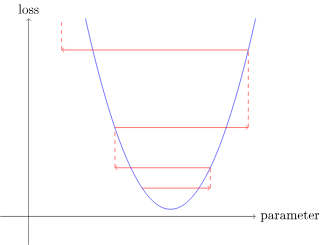

Although not depicted in the image above, you could imagine that the weight may start bouncing between either side of the curve instead of diverging towards the optimal value. 

## End-to-End SGD Implementation

Problem: We want to find a function that fits best to the data below. This data represents the speed of a rollercoaster as it approaches a peak (fast -> slow), reaches the peak (slowest), and then falls down the peak (slow -> fast). 

We need to use SGD to find this function because the measurements aren't precise and there won't be a function that fits perfectly.

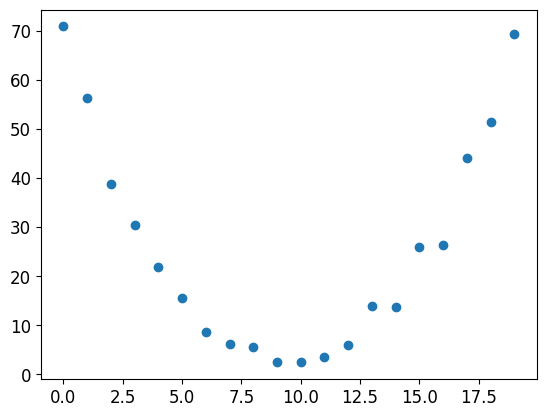

In [131]:
time = torch.arange(0, 20).float()

speed = torch.randn(20) * 3 + 0.75 * (time - 9.5)**2 + 1
plt.scatter(time, speed);

For this situation, we know that the function will be of the form $a * time^2 + b * time + c$

In [132]:
def f(t, params):
    a, b, c = params
    return a * (t**2) + (b * t) + c

Because we know it'll be a quadratic, we only need to find the best values for 3 parameters - `a`, `b`, and `c`. 

The idea is that if we can solve the problem for these parameters, the solution can be extrapolated out to more complicated functions with more parameters like in a neural network. 

Now to find what the "best values" look like, we'll need feedback from our loss metric.

In [133]:
def mse(preds, acts): return ((preds-acts)**2).mean()

With the preliminary functions written, let's go through the **7-step process for SGD**.

#### Step 1: Initialize the Parameters

In [134]:
params = torch.randn(3).requires_grad_()
params

tensor([-1.3133,  1.9144,  2.3847], requires_grad=True)

#### Step 2: Calculate the predictions

In [135]:
preds = f(time, params)

For the sake of visualizing how our predictions are matching up to the target data, we can create chart. 

*Not something you'd normally do but helpful for this learning process*

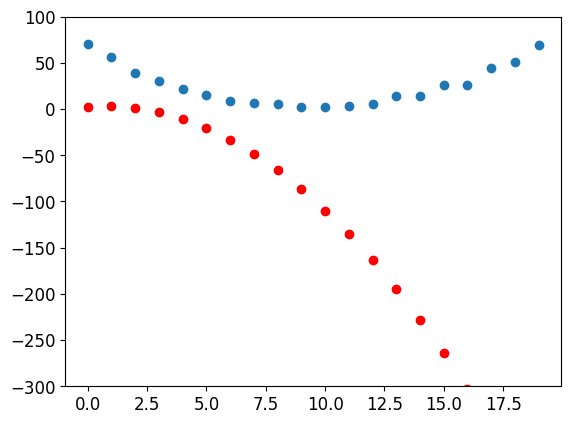

In [136]:
# Red = predictions, blue = target
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

Clearly the parameters are way off right now.

#### Step 3: Calculate the Loss

In [137]:
loss = mse(preds, speed)
loss

tensor(49277.0117, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the Gradients

In [138]:
loss.backward()
params.grad

tensor([-73991.7109,  -4708.9639,   -334.5522])

Our gradients indicate there all of our weights need to be **increased** to diverge closer to the optimal point. 

#### Step 5: Step the Weights

In [139]:
lr = 0.00001

# Need to use .data for data type compliance
params.data -= params.grad.data * lr 

# Clear gradients for next iteration
params.grad = None

# View updated params
params.data

tensor([-0.5733,  1.9615,  2.3880])

This implementation showcases how the chain rule is used in backpropagation to calculate gradients.

To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking `params` as an input, which was the object on which we originally called `requires_grad_` — which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

We can check to see if the loss has improved with the step we just made.

In [140]:
preds = f(time, params)
loss = mse(preds, speed)

loss

tensor(9835.4355, grad_fn=<MeanBackward0>)

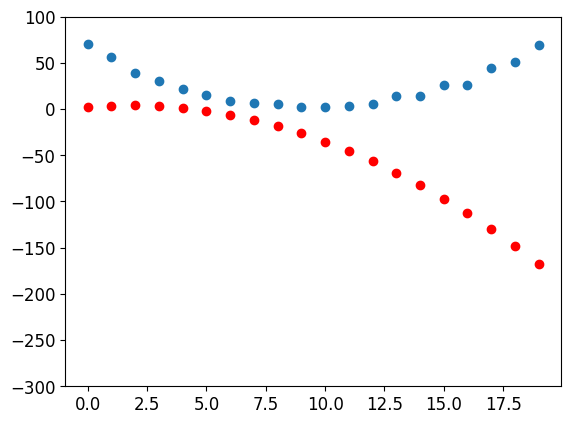

In [141]:
show_preds(preds)

A clear improvement from before, but still not optimal. Let's run this for a few epochs

In [142]:
def apply_step(params, print_loss=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= params.grad.data * lr
    params.grad = None
    if print_loss: print(loss.item())
    return preds 

#### Step 6: Repeat the Process

In [143]:
for i in range(10): apply_step(params)

9835.435546875
2371.87060546875
959.5226440429688
692.2498779296875
641.6602783203125
632.073974609375
630.24658203125
629.8873901367188
629.8060302734375
629.7772827148438


The loss is going down but as always, it's difficult to interpret exactly what this means. 

We can plot the process to get a visual understanding of how the model is improving.

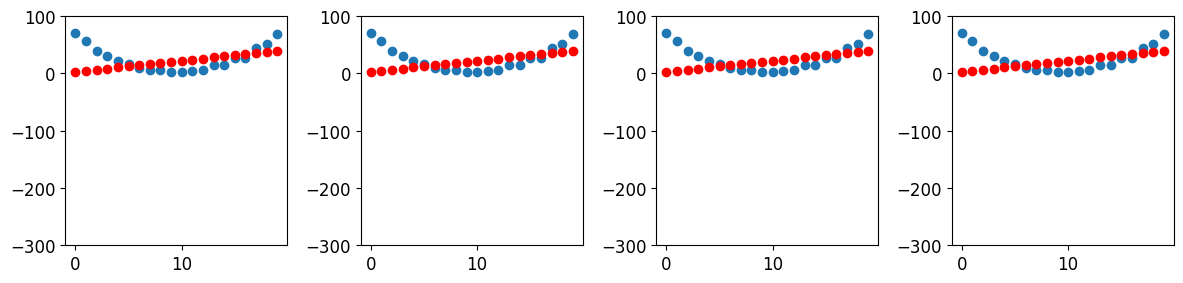

In [144]:
_, axs = plt.subplots(1, 4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, print_loss=False), ax)
plt.tight_layout()

It is now much more evident that the model is slowly improving and getting closer to the correct quadratic. 

#### Step 7: Stop

For the last 4 epochs, the model was making very minor improvements so this would be an appropriate place to stop.

## Summarizing Gradient Descent

We start by initializing our weights/parameters either randomly or from a pre-trained model (transfer learning). 

It is highly unlikely that these weights will be any good at matching with our data so we must improve them. This can be done by testing the output these weights give us against the targeted output (these will be training images or another form of training data), and use a loss function (such as MSE) to find our loss. 

Based on the loss value, we calculate our gradients through backpropagation. The gradient gives us information on which direction (increase or decrease) to shift our weights and by what magnitude. We don't actually change the weights by the magnitude of the gradient, we instead do a small step which is often 0.0001-0.1 of this value. 

This process repeats itself numerous times until we decide to stop training. 

*Everything above can be transferred over back to our MNIST problem except for the loss function.*

## MNIST Loss Function

The images will be our independent variables - `x`. We want our images in a single list of vectors (a rank-2 tensor with # of images & pixels per image) so we need to convert them over from their current matrix form (rank-3 tensor). 

This can be done by `view` which is a PyTorch method that changes the shape of a tensor without impacting its contents. When `-1` is passed to `view`, that tells `view` to make the last axis (pixel intensities) as large as necessary (go to 784 in this case) to fit all the data.

In [145]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

# Label 3s as "1" and 7s as "0s"
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

The 1st dimension of your `train_x` and `train_y` should always be the same (indicates they both have the same number of images). The 2nd dimension for `train_x` indicates the number of columns for each image - which in this case is 784 (one for every pixel intensity). The 2nd dimension for `train_y` represents the image label - which in this case is a single column that'll either say '7' or '3'.

We want to turn these train vectors into a `Dataset` since that's the form PyTorch's `Dataloader` will expect to receive the data. In PyTorch, a `Dataset` must return a tuple. The code below helps meet this requirement using `zip` and `list`.

In [162]:
train_dataset = list(zip(train_x, train_y))

# Image 1 from dataset
x, y = train_dataset[0]

x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

Let's do the same initialization for the validation set.

In [147]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dataset = list(zip(valid_x, valid_y))

Now we need to randomly initialize our starting weights

In [148]:
def init_params(size): return torch.randn(size).requires_grad_()

weights = init_params(28*28)

An important thing to note here: *what happens when our weight is multiplied with a pixel of value 0?* 

It would lead to our loss function and gradient equally 0 which is not accurate. Thus, considering that the formula for the simplest gradient/slope is $y = mx + b$ or in our case, $y = wx + b$ where the **w** stands for weights, we need a value for **b** to create a non-zero output for the loss function. 

The **b** is known as our bias. Both the weights and bias are our model's **parameters**. 

In [149]:
bias = init_params(1)

With the weights and bias established, we can make our first prediction

**Note**: This output still needs further processing to be mapped to an actual digit prediction (3 or 7). This is discussed soon.

In [150]:
(train_x[0] * weights.T).sum() + bias

tensor([2.9171], grad_fn=<AddBackward0>)

To complete the rest of the predictions, a for loop could be used but it would be very slow since loops don't run on the GPU.

Instead, we use **matrix multiplication** for every calculation of `(weights * image)`. This would replace the line  `(train_x[0] * weights.T).sum()`. All that would be left to do is add the bias. 

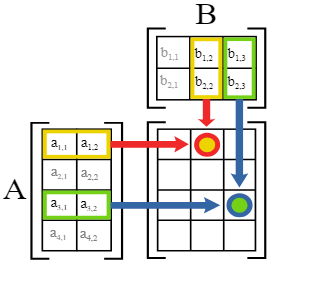

The image above depicts how **matrix multiplication** works. I will not explain it in-depth in these notes since I am already familiar with the topic. 

**Matrix A**: A *n x 784* matrix that represents our images. The rows represent different images (*n*) and each of the 784 columns contain one of the pixel intensities for that image. 

**Matrix B**: A *n x 784* matrix that represents our weights. The rows represent the number of **neurons** in the next layer (*n*) and each of the 784 columns contain one of the weights. 

The **neuron** is what performs the activation function (sigmoid, ReLU, etc.) and introduces non-linearity into the network. It's what would bring the prediction above of `14/9082` to a prediction of either 3 or 7.

In [151]:
# Matrix multiplication in Python is represented by '@' 

def linear1(batch): return batch@weights + bias

preds = linear1(train_x)
preds, preds.shape

(tensor([  2.9171,  -3.5244,  -4.6434,  ...,   1.5044, -16.3201,   2.6903], grad_fn=<AddBackward0>),
 torch.Size([12396]))

Next let's check our accuracy based of these initial weights. This will be our accuracy for differentiating between a 3 or 7.

We can first filter out some of the predictions by checking if `pred` for each image is > 0. This is because a negative number has no hope of matching to the label of '3' or '7'.

The accuracy can be calculated using broadcasting (loops are slow!).

In [152]:
def test_labels(preds): return (preds > 0.0).float() == train_y # .float needed to convert boolean ('True' or 'False') into number so it can be compared to the float values in train_y
correct_numbers = test_labels(preds)

correct_numbers

tensor([[ True, False, False,  ...,  True, False,  True],
        [ True, False, False,  ...,  True, False,  True],
        [ True, False, False,  ...,  True, False,  True],
        ...,
        [False,  True,  True,  ..., False,  True, False],
        [False,  True,  True,  ..., False,  True, False],
        [False,  True,  True,  ..., False,  True, False]])

In [153]:
# Accuracy
correct_numbers.float().mean().item() # .item() just returns the value without 'tensor()' wrapped around it

0.501362144947052

Accuracy is not great (a Python script that randomly picks 3 or 7 would be even better LOL!)

**Note**: The following section about loss function & sigmoids may be hard to follow - referencing [fastai chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) may provide greater clarity. 

To make it better, we need gradients to improve our model through SGD. To calculate gradients, we need a **loss function** (remember - gradients are a measure of how loss functions changes based on changes in the weights).

Although using the accuracy as our loss function seems tempting, it creates an issue where our gradient is almost always 0. This is because for accuracy to change in binary classification problems, it needs to go from predicting something is a 3 to a 7 (or vice versa). This is a big swing and with only small changes in our weights, it's highly unlikely we'll see this swing which will cause our accuracy to remain the same. Thus, we can't use accuracy as our loss function. 

Thus, we need a loss function with two arguments, `preds` and `targets`.

* `preds`: A rank-1 tensor, indexed over all images, which holds the predicted probability (between 0 and 1) that a number is or is not a 3. 
* `targets`: A rank-1 tensor, indexed over all images, which has a value of 0 (not a three) **or** 1 (three).

Let's write that function.

In [154]:
def mnist_loss(preds, targets):
    return torch.where(targets == 1, 1-preds, preds).mean()

The above will be our loss function. The method `torch.where` is basically saying `if targets = 1, do 1 - preds, else just use preds` - of course where you're iterating through each value in `preds` and `targets` simultaneously. This logic lets us get a low number if the prediction is accurate and a high number if the prediction is incorrect. `.mean` will then give us the overall loss based on all the computations. 

Again, the decision to use `torch.where` instead of some type of loop is so that it executes in C/CUDA speed as opposed to Python speed. 

One core assumption we've made with the implementation of this loss function is that the prediction *will be between 0 and 1*. As seen from our predictions a few cells before, this is not the case - the predictions are a bunch of different numbers (positive and negative). 

To solve this issue, we can use the `sigmoid` function which compresses any number to a value between 0 and 1.

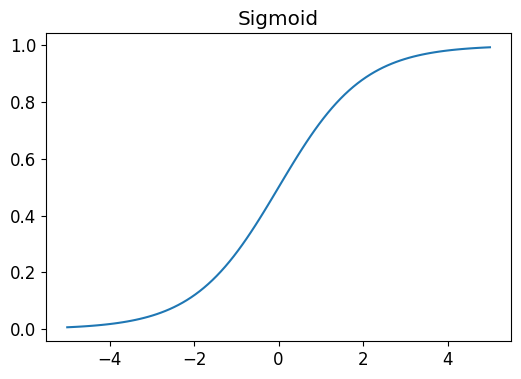

In [155]:
plot_function(torch.sigmoid, title='Sigmoid', min=-5, max=5)

We can now updates `mnist_lost` to first apply the `sigmoid` function to the predictions being passed through. Additionally, let's pass in the preds we have from before (the ones where our model has a 49% accuracy).

In [156]:
def mnist_loss(preds, targets):
    predictions = preds.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

mnist_loss(preds=preds, targets=train_y)

tensor(0.4987, grad_fn=<MeanBackward0>)

## SGD and Mini-Batches

With a loss function that can derive SGD, this section will dive deeper into updating the weights based on the gradients - an **optimization step**. 

An important variable to consider in taking your **optimization step** is how many data items (images) you let your loss average out over. You could, iterate over the predictions for the entire dataset, and then take the mean loss value. However, this would take a long time, especially as your dataset grows in size. Iterating over just a single item would be quick but because it's low information, the gradient would be imprecise and unstable. 

Instead, we calculate the loss of a **mini-batch**. The number of data items in the **mini-batch** is called the **batch size**. Using mini-batches will help you get more precise and stable gradients and thus, better results on your model. 

Why? Using batches as opposed to iterating over the entire dataset and then taking our losses is analogous to writing a multiple-choice test. If you were taking a 50 question multiple-choice test, and every 5 questions in, you were told which of your answers were right and which were wrong, that'll likely help you in answer the next 5 questions more accurately. The same idea applies with mini-batches. Being able to get feedback to adjust your weights every few images is better than waiting until you do the entire 50-question test, learn what you did wrong, and then do an entire other test before getting feedback again on that one. 

Mini-batches also help our GPUs. GPUs are really good when they have lots of tasks to do, so passing in a bunch of mini-batches helps achieve exactly that.

Changing things up during training helps keep our model on edge and learn more. So, we can use the fastai `Dataloader` class to shuffle the data items in each mini-batch after every epoch. This is done by shuffling the dataset itself so that when the mini-batches are created, they contain different data items. 

In [157]:
# An example of how DataLoaders work - in this case we're creating 3 mini-batches
num_set = range(15)
dl = DataLoader(num_set, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3,  2, 10,  9, 13]),
 tensor([14,  6,  8,  0,  1]),
 tensor([ 7,  4,  5, 12, 11])]

Within each mini-batch, we want both the independent and dependent variables of our dataset (x - pixel intensities, y - label).

A collection that contains tuples of independent and dependent variables in PyTorch is a `Dataset`. 

In [158]:
# An example of what a Dataset looks like in PyTorch
ds = L(enumerate(string.ascii_uppercase))
ds

(#26) [(0, 'A'),(1, 'B'),(2, 'C'),(3, 'D'),(4, 'E'),(5, 'F'),(6, 'G'),(7, 'H'),(8, 'I'),(9, 'J')...]

A `Dataset` can be passed as the first argument to the `Dataloader` class, which creates mini-batches of tuples containing tensors inside.

In [159]:
dl = DataLoader(ds, batch_size=5, shuffle=True)
list(dl)

[(tensor([ 3, 16, 17,  8,  7]), ('D', 'Q', 'R', 'I', 'H')),
 (tensor([ 2, 10, 22,  4, 14]), ('C', 'K', 'W', 'E', 'O')),
 (tensor([25, 15,  1, 12, 19]), ('Z', 'P', 'B', 'M', 'T')),
 (tensor([ 5,  9, 11,  0, 23]), ('F', 'J', 'L', 'A', 'X')),
 (tensor([21, 13, 18, 20,  6]), ('V', 'N', 'S', 'U', 'G')),
 (tensor([24]), ('Y',))]

## Putting It All Together

We want to copy the method we saw in our SGD section: 

```
for x, y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

Start by re-initializing the parameters

In [198]:
weights = init_params(28*28)
bias = init_params(1)

Create a `Dataloader` from a  our `train_dataset` we made a little while back

In [199]:
dl = DataLoader(train_dataset, batch_size=256)

# Take the first mini-batch from our DataLoader
x_first, y_first = first(dl)

x_first.shape, y_first.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Now, we do the same with our `valid_dataset` (also made a little bit ago)

In [200]:
valid_dl = DataLoader(valid_dataset, batch_size=256)

We'll make a mini-batch size of just 4 data items for testing purposes

In [201]:
train_test_batch = train_x[:4]
valid_test_batch = train_y[:4]

train_test_batch.shape, valid_test_batch.shape

(torch.Size([4, 784]), torch.Size([4, 1]))

In [202]:
preds = linear1(train_test_batch)
preds

tensor([ 1.9852,  0.5185,  1.6748, 16.1819], grad_fn=<AddBackward0>)

Now that we have our predictions and targets (`valid_test_batch`), we can calculate the loss

In [203]:
trgs = valid_test_batch

loss = mnist_loss(preds, trgs)
loss

tensor(0.1629, grad_fn=<MeanBackward0>)

Based on the loss, the gradients can be computed

In [204]:
loss.backward()

weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784]), tensor(-0.0169), tensor([-0.1182]))

Like we did in our quadratic function example, we can put this entire process into a single function.

In [205]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

calc_grad(train_test_batch, trgs, linear1)

weights.grad.mean(), bias.grad

(tensor(-0.0338), tensor([-0.2365]))

If we were to try and run `calc_grad()` again, we'd notice a critical error - the gradients from before and the above actually add up!

In [206]:
calc_grad(train_test_batch, trgs, linear1)

weights.grad.mean(), bias.grad

(tensor(-0.0506), tensor([-0.3547]))

This occurs because `loss.backward()` adds the gradients of `loss` (**-0.0338** and **-0.2365**) to the gradients already stored (**-0.0169** and **-0.1182**). This accumulation of gradients from the past two calls will lead to our gradients just getting larger and larger and not being effective in updating our weights.

To avoid this, we use `.grad.zero)()` on our `weights` and `bias` to set the gradient to 0 before the next call of `calc_grad`.

`.grad.zero_()` is an **in-place operation** (identified by the `_` at the end) which modifies the object in place.

In [209]:
weights.grad.zero_()
bias.grad.zero_();

With all these functionalities sorted out, we can write a function to update the weights and biases based on the gradient and learning rate.